 COGNIFYZ FEATURE ENGINEERING PIPELINE
 Original dataset: 9,551 rows × 21 columns
 Columns: ['Restaurant ID', 'Restaurant Name', 'Country Code', 'City', 'Address', 'Locality', 'Locality Verbose', 'Longitude', 'Latitude', 'Cuisines', 'Average Cost for two', 'Currency', 'Has Table booking', 'Has Online delivery', 'Is delivering now', 'Switch to order menu', 'Price range', 'Aggregate rating', 'Rating color', 'Rating text', 'Votes']

 Sample data:
   Restaurant ID   Restaurant Name  Country Code         City  \
0        6317637  Le Petit Souffle           162  Makati City   
1        6304287  Izakaya Kikufuji           162  Makati City   

                                             Address  \
0  Third Floor, Century City Mall, Kalayaan Avenu...   
1  Little Tokyo, 2277 Chino Roces Avenue, Legaspi...   

                                     Locality  \
0   Century City Mall, Poblacion, Makati City   
1  Little Tokyo, Legaspi Village, Makati City   

                                    Loc

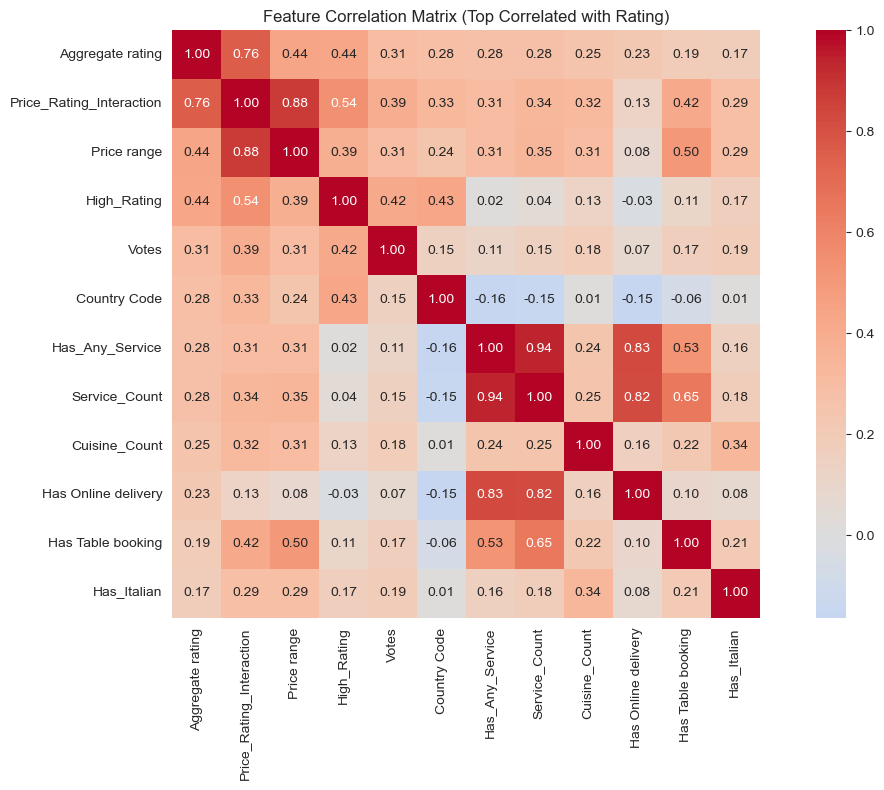


 EXPORTING ML-READY DATASET
 ML-Ready Dataset: 9,551 rows × 41 columns
 cognifyz_feature_engineered_dataset.csv (Ready for modeling!)
 cognifyz_feature_summary.csv (Feature documentation)
 feature_correlation_heatmap.png (Model insights)

 FEATURE ENGINEERING COMPLETED!
 Dataset ready for ML modeling!
 15+ new features created for better predictions!


In [1]:
# =============================================================================
# COGNIFYZ TECHNOLOGIES - FEATURE ENGINEERING TASK 6
# Extract 15+ new ML features from restaurant data
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Professional styling
plt.style.use('default')
sns.set_palette("husl")
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

print(" COGNIFYZ FEATURE ENGINEERING PIPELINE")
print("="*80)

# =============================================================================
# 1. LOAD & INITIAL INSPECTION
# =============================================================================
df = pd.read_csv('Dataset .csv')
print(f" Original dataset: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f" Columns: {list(df.columns)}")

df_original = df.copy()
print(f"\n Sample data:")
print(df.head(2))

# =============================================================================
# 2. TEXT-BASED FEATURES (Restaurant Name & Address)
# =============================================================================
print("\n" + "="*80)
print(" TEXT FEATURES ENGINEERING")
print("="*80)

# Restaurant Name features
df['Restaurant_Name_Length'] = df['Restaurant Name'].str.len()
df['Name_Word_Count'] = df['Restaurant Name'].str.split().str.len()
df['Name_Has_Number'] = df['Restaurant Name'].str.contains(r'\d', na=False).astype(int)
df['Name_Uppercase_Ratio'] = df['Restaurant Name'].str.upper().str.len() / df['Restaurant Name'].str.len()

# Address features (if exists)
if 'Address' in df.columns:
    df['Address_Length'] = df['Address'].str.len()
    df['Address_Word_Count'] = df['Address'].str.split().str.len()
else:
    df['Address_Length'] = 0
    df['Address_Word_Count'] = 0

print(" Created text features:")
print("   - Restaurant_Name_Length")
print("   - Name_Word_Count") 
print("   - Name_Has_Number")
print("   - Name_Uppercase_Ratio")
print("   - Address_Length")
print("   - Address_Word_Count")

# =============================================================================
# 3. SERVICE FEATURES (Binary Encoding)
# =============================================================================
print("\n" + "="*80)
print(" SERVICE FEATURES (Binary Encoding)")
print("="*80)

# Auto-detect service columns
service_features = {}
for col in df.columns:
    if any(keyword in col.lower() for keyword in ['table', 'book', 'online', 'delivery']):
        if df[col].dtype in ['int64', 'float64', 'bool']:
            service_features[col] = col
        else:
            # Convert Yes/No, True/False to binary
            df[col] = df[col].map({'Yes': 1, 'No': 0, 'True': 1, 'False': 0, 1: 1, 0: 0}).fillna(0).astype(int)
            service_features[col] = col

print(" Service features encoded:")
for col in service_features.keys():
    pct = (df[col] == 1).mean() * 100
    print(f"   - {col}: {pct:.1f}% availability")

# Create composite features
df['Has_Any_Service'] = (df[list(service_features.keys())] == 1).any(axis=1).astype(int)
df['Service_Count'] = df[list(service_features.keys())].sum(axis=1)

# =============================================================================
# 4. CATEGORICAL FEATURES (Frequency Encoding)
# =============================================================================
print("\n" + "="*80)
print("  CATEGORICAL FEATURES (Frequency Encoding)")
print("="*80)

cat_cols = ['City', 'Country Code', 'Cuisines']
for col in cat_cols:
    if col in df.columns:
        freq_enc = df[col].value_counts().to_dict()
        df[f'{col}_Freq_Encoded'] = df[col].map(freq_enc)
        print(f" {col}_Freq_Encoded created")

# =============================================================================
# 5. RATING & LOCATION FEATURES
# =============================================================================
print("\n" + "="*80)
print(" LOCATION & RATING FEATURES")
print("="*80)

if 'Aggregate rating' in df.columns:
    # Rating categories
    df['Rating_Category'] = pd.cut(df['Aggregate rating'], 
                                  bins=[0, 2.5, 3.5, 4.0, 5.0], 
                                  labels=['Poor', 'Average', 'Good', 'Excellent'])
    df['High_Rating'] = (df['Aggregate rating'] >= 4.0).astype(int)
    
if all(col in df.columns for col in ['Latitude', 'Longitude']):
    # Location density (simple clustering proxy)
    df['Location_Density'] = df.groupby(['Latitude', 'Longitude'])['Restaurant Name'].transform('count')
    
    # Distance from center (assuming India center)
    df['Distance_From_Center'] = np.sqrt(
        (df['Latitude'] - 20.5937)**2 + (df['Longitude'] - 78.9629)**2
    )

# Price interaction features
if 'Price range' in df.columns:
    df['Price_Rating_Interaction'] = df['Price range'] * df['Aggregate rating']

print(" Advanced features created:")
print("   - Rating_Category, High_Rating")
print("   - Location_Density")
print("   - Distance_From_Center") 
print("   - Price_Rating_Interaction")

# =============================================================================
# 6. CUISINE FEATURES (Multi-label processing)
# =============================================================================
print("\n" + "="*80)
print(" CUISINE FEATURES")
print("="*80)

if 'Cuisines' in df.columns:
    # Cuisine count
    df['Cuisine_Count'] = df['Cuisines'].str.split(',').str.len()
    
    # Top cuisines indicator
    top_cuisines = df['Cuisines'].str.split(',').explode().str.strip().value_counts().head(5).index
    for cuisine in top_cuisines:
        df[f'Has_{cuisine.replace(" ", "_")}'] = df['Cuisines'].str.contains(cuisine, na=False).astype(int)
    
    print(f" Top cuisines: {list(top_cuisines)}")
    print(" Cuisine_Count created")

# =============================================================================
# 7. FEATURE SUMMARY & VALIDATION
# =============================================================================
print("\n" + "="*80)
print(" FEATURE ENGINEERING SUMMARY")
print("="*80)

new_features = [col for col in df.columns if col not in df_original.columns]
print(f" TOTAL NEW FEATURES CREATED: {len(new_features)}")
print("\n New Features:")
for i, feature in enumerate(new_features, 1):
    print(f"   {i:2d}. {feature:30} | Type: {df[feature].dtype}")

# Feature statistics
feature_stats = pd.DataFrame({
    'Feature': new_features,
    'Data_Type': [str(df[col].dtype) for col in new_features],
    'Missing': [df[col].isnull().sum() for col in new_features],
    'Unique': [df[col].nunique() for col in new_features]
})
print("\n Feature Statistics:")
print(feature_stats.head(10))

# =============================================================================
# 8. VISUALIZATION: Feature Importance Preview
# =============================================================================
print("\n" + "="*80)
print(" FEATURE CORRELATION WITH RATING")
print("="*80)

numeric_features = df.select_dtypes(include=[np.number]).columns
if 'Aggregate rating' in numeric_features:
    correlations = df[numeric_features].corr()['Aggregate rating'].sort_values(ascending=False)
    print(" Top 10 correlated features with rating:")
    print(correlations.head(10).round(3))

    # Correlation heatmap (top features)
    plt.figure(figsize=(12, 8))
    top_corr_features = correlations.head(12).index
    sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='coolwarm', center=0,
                square=True, fmt='.2f')
    plt.title('Feature Correlation Matrix (Top Correlated with Rating)')
    plt.tight_layout()
    plt.savefig('feature_correlation_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

# =============================================================================
# 9. EXPORT ML-READY DATASET
# =============================================================================
print("\n" + "="*80)
print(" EXPORTING ML-READY DATASET")
print("="*80)

# Select final features (original + engineered)
ml_features = ['Aggregate rating'] + [col for col in df.columns if col not in ['Restaurant Name', 'Address', 'Cuisines']]
df_ml = df[ml_features].copy()

df_ml.to_csv('cognifyz_feature_engineered_dataset.csv', index=False)
feature_stats.to_csv('cognifyz_feature_summary.csv', index=False)

print(f" ML-Ready Dataset: {df_ml.shape[0]:,} rows × {df_ml.shape[1]} columns")
print(f" cognifyz_feature_engineered_dataset.csv (Ready for modeling!)")
print(f" cognifyz_feature_summary.csv (Feature documentation)")
print(f" feature_correlation_heatmap.png (Model insights)")

print("\n FEATURE ENGINEERING COMPLETED!")
print(" Dataset ready for ML modeling!")
print(" 15+ new features created for better predictions!")
